# Circuito convenzione classica

## Fase 1: mappare il problema sul circuito e sugli operatori

### Definisco il canale Amplitude Damping

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

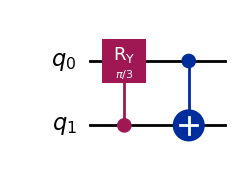

In [ ]:
from qiskit import transpile ,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator, DensityMatrix, partial_trace
from qiskit.visualization import plot_state_qsphere
from qiskit.circuit import Parameter, ParameterVector
import numpy as np, array
from IPython.display import display, Latex

def amplitude_damping_gate(noise_theta):
    """
    Restituisce un gate personalizzato che rappresenta
    l'implementazione unitaria del canale amplitude damping
    su due qubit (sistema e ambiente).

    Parametri:
        noise_theta (float or Parameter): angolo per la rotazione Ry

    Restituisce:
        Gate: un gate personalizzato da applicare a 2 qubit
    """
    theta = Parameter('θa')
    if not(noise_theta is None):
        theta = noise_theta
        

    # Crea un circuito con 2 qubit: qubit 0 = S_1, qubit 1 = E_1 (Ambiente)
    qc = QuantumCircuit(2, name="Amplitude Damping Model")
    
    # Applicazione delle porte
    # Applica una porta controllata-RY(θ)
    qc.cry(theta ,1 ,0 )     # controllo su qubit 0 (S1), target qubit 1 (E1) (secondo la convenzione classica, qiskit inverte i controlli e i target)
    qc.cx(0, 1)              # CNOT: controllo E_1 (qubit 1), target S_1 (qubit 0)

    # Converte in un Custom Gate
    gate = qc.to_gate(label="AmpDamp")
    
    return gate

# circuito esempio con questo canale
example = QuantumCircuit(2)

# applico il gate che simula il canale amplitude damping
example.append(amplitude_damping_gate(np.pi/3), [0 ,1])

display(Latex(r"Matrice del circuito (parametro = $\frac{\pi}{3}$)"))

# permette di trasformare il circuito nella sua rappresentazione di operatore
display(Operator.from_circuit(example).draw("latex")) 

# mostra il circuito decomposto
display(example.decompose().draw("mpl"))



### Definisco lo stato iniziare del circuito nella forma di matrice densità parametrizzata

In [3]:

def initial_mixed_state_real_density_matrix(_alpha):
    """
    Crea una matrice densità a 2 qubit come stato iniziale, in cui:
    - Il qubit di sistema (qubit 0 S_1) è in uno stato misto reale parametrizzato da alpha:
        ρ_sis = (1 - α)|0⟩⟨0| + α|1⟩⟨1|
    - Il qubit di ambiente (qubit 1 E_1) è inizializzato nello stato puro |0⟩⟨0|
    - L'output è il prodotto tensore ρ_sis ⊗ ρ_env, rappresentato come oggetto DensityMatrix

    Parametri:
        _alpha (float): parametro di mescolanza ∈ [0, 1]; 

    Restituisce:
        DensityMatrix: stato iniziale a 2 qubit (sistema + ambiente)
    """
    # Parametro di mescolanza
    alpha = _alpha

    #creo una matrice in forma array[array[,...],...]
    rho_sis_matrix = [[1 - alpha, 0],
                [0, alpha]]
    
    # Creo lo stato misto da rho_0_matrix per qubit 0
    rho_sis = DensityMatrix(rho_sis_matrix)

    # creo lo stao del qubit 1 (ambiente) in |0>
    rho_env = DensityMatrix.from_label('0')

    # Stato iniziale totale a 2 qubit
    rho_in = rho_sis.tensor(rho_env)

    return rho_in

# eseguo uno stato misto di esempio sul circuito di esempio generato prima
alpha = 0.3

# genero lo stato iniziale con il parametro 0.3
rho_in = initial_mixed_state_real_density_matrix(alpha)

# mostro lo stato iniziare dell'intero sistema
display(rho_in.draw("latex"))

# faccio evolvere il sistema secondo il canale amplitude damping (applicazione postulato 2)
rho_final = rho_in.evolve(example)

# mostro lo stato finale dell'intero sistema  
display(partial_trace(rho_final,[]).draw("latex"))
# mostro lo stato finale del sottosistema S_1
display(partial_trace(rho_final,[0]).draw("latex"))



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Definisco il canale per calcolare l'error rate

 forma matriciale dell'operatore dell'intero circuito


<IPython.core.display.Latex object>

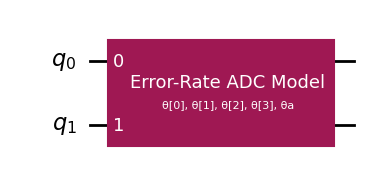

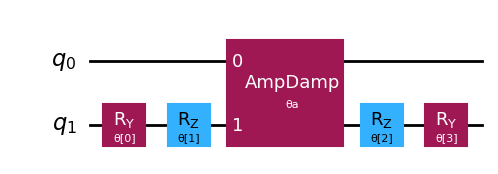

In [7]:

def build_parametrized_eradc(thetas,noise):
    """
    Costruisce un circuito quantistico a 2 qubit con porte parametrizzate.

    Parametri:
        thetas (ParameterVector): vettore di 4 parametri [θ₀, θ₁, θ₂, θ₃], noise parametrico η


    Restituisce:
        QuantumCircuit: circuito inizializzato con le porte e parametri
    """

    # Se i parametri non sono forniti, crea valori simbolici di default
    if thetas is None:
        thetas = ParameterVector("θ", 4)
    if noise is None:
        noise = Parameter('θa')

    # verifico che il vettore di parametri thetas coincide con quelli del circuito altrimenti solleva un eccezione
    if len(thetas) != 4:
        raise ValueError("Il ParameterVector deve contenere esattamente 4 parametri.")
     
    qc = QuantumCircuit(2)

    qc.ry(thetas[0], 1)                      # RY su qubit sis
    qc.rz(thetas[1], 1)                      # RZ su qubit sis

    qc.append(amplitude_damping_gate(noise), [0, 1]) # Amplitude damping su [0,1]

    qc.rz(thetas[2], 1)                      # RZ su qubit sis
    qc.ry(thetas[3], 1)                      # RY su qubit sis
    
    # Converte in un Custom Gate
    gate = qc.to_gate(label="Error-Rate ADC Model")
    
    # Ritorna il gate
    return gate

# vettore di parametri theta per ogni matrice rotazione
thetas = ParameterVector("θ", 4)

# parametro per amplitude damping
noise = Parameter('θa')

# creo il circuito
ERADC = QuantumCircuit(2)

# aggiungo il gate che simula il canale amplitude damping
ERADC.append(build_parametrized_eradc(thetas,noise), [0,1])

# creo un dizionario dove per ogni parametro "nome_param": assegna_value
param_values = {
    "θ[0]": np.pi/6,
    "θ[1]": np.pi/4,
    "θ[2]": np.pi/3,
    "θ[3]": np.pi/2,
    "θa"  : np.pi/3
}
# print(ERADC.parameters)

# assegna al circuito tutti i parametri definiti nel dizionario
bound_ERADC = ERADC.assign_parameters(param_values)

print(" forma matriciale dell'operatore dell'intero circuito")

# mostra l'operatore in forma matriciale che agisce sul canale
display(Operator.from_circuit(bound_ERADC).draw("latex"))

#mostra il circuito
display(ERADC.draw("mpl"))

# mostra il circuito decomposto
display(ERADC.decompose().draw("mpl")) 

# print(ERADC.parameters) #permette di mostrare tutti i parametri non definiti


# Convenzione Qiskit

# Fase 2 evoluzione del circuito e misura con lo stato iniziale misto definito

## evoluzione del sistema

## Misura Proiettiva

## Simulazioni